In [58]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
import seaborn as sns

import torchvision.transforms as tfs
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

In [59]:
plt.style.use('default')
sns.set(rc={'figure.figsize':(8, 6)})
sns.set_style('white')
sns.despine()

<Figure size 800x600 with 0 Axes>

In [60]:
url = 'https://raw.githubusercontent.com/tsebaka/ML-practice/main/Deep%20Learning/Neural%20Networks/FCNN/data.csv'
data = pd.read_csv(url)

In [61]:
labels = data['class'].values

In [62]:
data

,x,y,class
0,3.238258,0.795599,1
1,4.189054,1.631411,-1
2,4.214798,0.019202,1
3,4.432564,0.586037,-1
4,3.503429,0.496178,1
...,...,...,...
2995,4.149008,1.004875,-1
2996,2.632955,0.136764,1
2997,2.805922,1.457728,-1
2998,3.217395,1.425684,1


In [63]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.tensor(X.values)
        self.y = torch.tensor(y.values) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

def create_datasets(data, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    num_train = int(len(data)*p_train)
    num_val = int(len(data)*p_val)
    num_test = int(len(data)*p_test)

    data_train = data[:num_train]
    data_valid = data[num_train:num_train+num_val]
    data_test = data[-num_test:]

    X_train, y_train = data_train.drop(columns='class'), data_train['class']
    X_val, y_val = data_valid.drop(columns='class'), data_valid['class']
    X_test, y_test = data_test.drop(columns='class'), data_test['class']

    data_train = dataset_class(X_train, y_train)
    data_valid = dataset_class(X_val, y_val)
    data_test = dataset_class(X_test, y_test)

    return data_train, data_valid, data_test


In [64]:
data_train, data_valid, data_test = create_datasets(data, Dataset)

In [65]:
train_dataloader = DataLoader(data_train, 
                              batch_size=1, 
                              drop_last=True)
valid_dataloader = DataLoader(data_valid, 
                              batch_size=1,
                              drop_last=True)
test_dataloader = DataLoader(data_test, 
                              batch_size=1, 
                             drop_last=True)

In [66]:
loaders = {'train': train_dataloader, 'valid': valid_dataloader}

In [67]:
import torch
from torch import nn
from torch.nn import functional as F



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 2)
    
    def forward(self, x):
        x = x.type(torch.float32)

        x = self.fc1(x)
        x = F.tanh(x)
        x = x[0][0] * x[0][1]
        x = F.tanh(x)

        return x
net = Net()
net

Net(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
)

In [68]:
# hyper parameters
max_epoch = 100

# loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3)

# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [69]:
accuracy = {'train': [], 'valid': []}
flag = False

for epoch in range(max_epoch):
    if flag:
        break
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == 'train':
                net.train()
                output = net.forward(x_batch)
                loss = max(0, -output * y_batch[0])
                optimizer.zero_grad()
                if (loss):
                    loss.backward()
                    optimizer.step()
            else:
                net.eval()
                with torch.no_grad():
                    output = net.forward(x_batch)
            if output > 0:
                preds = 1
            else:
                preds = -1
            all = 1
            correct = torch.tensor(y_batch[y_batch==preds].size()) 
            epoch_correct += correct.item()
            epoch_all += all
        if k == 'train':
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
        if epoch_correct/epoch_all > 0.99:
            flag = True
            break

Epoch: 1
Loader: train. Accuracy: 0.84
Loader: valid. Accuracy: 0.9566666666666667
Epoch: 2
Loader: train. Accuracy: 0.9416666666666667
Loader: valid. Accuracy: 0.9733333333333334
Epoch: 3
Loader: train. Accuracy: 0.9616666666666667
Loader: valid. Accuracy: 0.9633333333333334
Epoch: 4
Loader: train. Accuracy: 0.9845833333333334
Loader: valid. Accuracy: 0.99
Epoch: 5
Loader: train. Accuracy: 0.9854166666666667
Loader: valid. Accuracy: 0.97
Epoch: 6
Loader: train. Accuracy: 0.9916666666666667


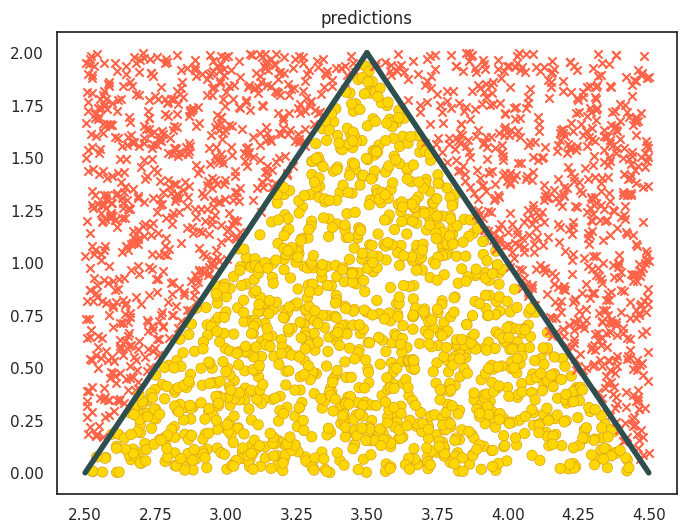

In [70]:
plt.plot([2.5, 3.5], [0, 2], color='darkslategray', linewidth=4)
plt.plot([4.5, 3.5], [0, 2], color='darkslategray', linewidth=4)
import matplotlib.patheffects as pe


for k, dataloader in loaders.items():
    for x_batch, y_batch in dataloader:
        x, y, label = x_batch[0][0], x_batch[0][1], y_batch[0]
        pred = net.forward(x_batch)
        if pred > 0:
            plt.scatter(x, y, color='gold', path_effects=[pe.Stroke(linewidth=2, foreground='goldenrod'), pe.Normal()])
        else:
            plt.scatter(x, y, marker="x", color='tomato')

plt.title('predictions')
plt.show()